In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
news_scores = { 
    "dutch" : {
        'Telegraaf' : 3.6,
        'Geenstijl' : 3.6,
        'RTL' : 3.4,
        'NOS' : 3.3,
        'NU.nl' : 3.3,
        'AD' : 3.4,
        'Volkskrant' : 2.9
    },

    "german" : {
        'Bild' : 3.1,
        'FAZ' : 2.9,
        'RTL' : 3.0,
        'Sat1' : 3.0,
        'Sz' : 2.8,
        'ARD' : 2.9,
        'Der Spiegel' : 2.8
    },   
    "french" : {
        'TF1' : 3.3,
        'Le Figaro' : 3.3,
        'BFM' : 3.2,
        "L'Express" : 2.9,
        'Le Monde' : 2.9,
        'France 2' : 3.1,
        'Libération' : 2.5,
        'Mediapart' : 2.4
    }
}


In [23]:
news_scores = {'dutch': {
    'Telegraaf': 1.0,
    'Geenstijl': 1.0,
    'RTL': 0.6666666666666665,
    'NOS': 0.49999999999999956,
    'NU.nl': 0.49999999999999956,
    'AD': 0.6666666666666665,
    'Volkskrant': -0.16666666666666674,
    }, 'german': {
    'Bild': 0.16666666666666674,
    'FAZ': -0.16666666666666674,
    'RTL': 0.0,
    'Sat1': 0.0,
    'Sz': -0.3333333333333336,
    'ARD': -0.16666666666666674,
    'Der Spiegel': -0.3333333333333336,
    }, 'french': {
    'TF1': 0.49999999999999956,
    'Le Figaro': 0.49999999999999956,
    'BFM': 0.3333333333333335,
    "L'Express": -0.16666666666666674,
    'Le Monde': -0.16666666666666674,
    'France 2': 0.16666666666666674,
    'Libération': -0.8333333333333333,
    'Mediapart': -1.0,
    }}


In [24]:
# mean_dutch = sum(news_scores['dutch'].values()) / len(news_scores['dutch'])
# mean_german = sum(news_scores['german'].values()) / len(news_scores['german'])
# print(f"Mean for Dutch: {mean_dutch:.3f}")
# print(f"Mean for German: {mean_german:.3f}")

In [25]:
# normalizer

all_scores = []
for language in news_scores.values():
    all_scores.extend(language.values())
# Step 2: Calculate the overall min and max values
min_score = min(all_scores)
max_score = max(all_scores)
# Step 3: Normalize the scores to the range [-1, 1]
normalized_scores = {}
for language, sites in news_scores.items():
    normalized_scores[language] = {
        site: (2 * (score - min_score) / (max_score - min_score)) - 1
        for site, score in sites.items()
    }
# Print the normalized scores
print(normalized_scores)

{'dutch': {'Telegraaf': 1.0, 'Geenstijl': 1.0, 'RTL': 0.6666666666666665, 'NOS': 0.49999999999999956, 'NU.nl': 0.49999999999999956, 'AD': 0.6666666666666665, 'Volkskrant': -0.16666666666666674}, 'german': {'Bild': 0.16666666666666674, 'FAZ': -0.16666666666666674, 'RTL': 0.0, 'Sat1': 0.0, 'Sz': -0.3333333333333336, 'ARD': -0.16666666666666674, 'Der Spiegel': -0.3333333333333336}, 'french': {'TF1': 0.49999999999999956, 'Le Figaro': 0.49999999999999956, 'BFM': 0.3333333333333335, "L'Express": -0.16666666666666674, 'Le Monde': -0.16666666666666674, 'France 2': 0.16666666666666674, 'Libération': -0.8333333333333333, 'Mediapart': -1.0}}


In [26]:
scores_per_place = {
                    1: 0.28,
                    2: 0.25,
                    3: 0.22,
                    4: 0.15,
                    5: 0.10
                    }

In [27]:
a = [1, 2, 3]
a.pop(2)
print(a)

[1, 2]


In [28]:
def process_score(row, start, xend, language):
    scores = news_scores[language]
    score = 0
    nr_of_found = 0
    for site in row.index[start+1:xend+1]:
        # print(site)
        site_stripped = site[:-2] 
        site_place = row[site]
        if site_place != 0:
            if isinstance(site_place, str):
                    if ',' in site_place:
                        splitted = site_place.split(',')
                        for spl in splitted:
                            score += scores[site_stripped]
                            nr_of_found+=1
                            
                    else:
                        site_place = int(site_place)
                        score += scores[site_stripped]
                        nr_of_found+=1
            else:
                score += scores[site_stripped]
                nr_of_found+=1
    if score != 0:
        score = score/nr_of_found
    else:
        score = 0
    return score

In [29]:
def compute_scores(df, lang):
    # compute score per query
    df['score-c'] = df.apply(
            lambda row: process_score(row, 0, 7, lang), axis=1
        )
    df['score-d'] = df.apply(
            lambda row: process_score(row, 7, 14, lang), axis=1
        )
    df['score-g'] = df.apply(
            lambda row: process_score(row, 14, 21, lang), axis=1
        )

    # compute avg
    # Replace 0 with NaN for specific columns
    cols_to_average = ['score-c', 'score-d', 'score-g']
    df[cols_to_average] = df[cols_to_average].replace(0, pd.NA)
    df['score-avg'] = df[cols_to_average].mean(axis=1)
    return df

In [137]:
def plot_avg(df, title):

    plt.figure(figsize=(8, 4))
    # plt.scatter(df['score-avg'], [0] * len(df), color='b', alpha=0.7)
    sns.boxplot(x=df['score-avg'], color='#8ecae6', zorder=1)
    plt.scatter(df['score-avg'], [0] * len(df), color='#023e8a', alpha=0.9, s=50, zorder=2)

    offset = 0.007  # Offset value to prevent overlap
    for i, value in enumerate(df['score-avg']):
        # Adjust the y position slightly for each label to avoid overlap
        plt.text(value, (-offset * (i + 1)) -0.04, str(df['Participant'].iloc[i]), 
                horizontalalignment='center', verticalalignment='top', 
                color='black', size=8)
    
    plt.xlim(-1, 1)
    plt.xlabel('Score Average')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()
    
    print("Variance:", np.var(df['score-avg']))


In [138]:
file_path_dutch = "IR_data_Dutch.csv"
file_path_german = "IR_data_German.csv"
file_path_french = "IR_data_French.csv"

dutch_df = pd.read_csv(file_path_dutch)
dutch_df = dutch_df.fillna(0)

german_df = pd.read_csv(file_path_german)
german_df = german_df.fillna(0)

french_df = pd.read_csv(file_path_french)
french_df = french_df.fillna(0)

# print(dutch_df)

dutch_df_extended = compute_scores(dutch_df, 'dutch')
german_df_extended = compute_scores(german_df, 'german')
french_df_extended = compute_scores(french_df, 'french')

In [139]:
df_together = pd.concat([dutch_df_extended, german_df_extended], ignore_index=True)
df_together = pd.concat([df_together, french_df_extended], ignore_index=True)


In [140]:
df_m = df_together[df_together['Gender'] == 'm']  # Male DataFrame
df_f = df_together[df_together['Gender'] == 'f']  # Female DataFrame

In [141]:
print(len(df_m))
print(len(df_f))
df_m

13
14


,Participant,Telegraaf-c,Geenstijl-c,RTL-c,NOS-c,NU.nl-c,AD-c,Volkskrant-c,Telegraaf-d,Geenstijl-d,RTL-d,NOS-d,NU.nl-d,AD-d,Volkskrant-d,Telegraaf-g,Geenstijl-g,RTL-g,NOS-g,NU.nl-g,AD-g,Volkskrant-g,Age,Gender,Nationality,Location,score-c,score-d,score-g,score-avg,Bild-c,FAZ-c,Sat1-c,Sz-c,ARD-c,Der Spiegel-c,Bild-d,FAZ-d,Sat1-d,Sz-d,ARD-d,Der Spiegel-d,Bild-g,FAZ-g,Sat1-g,Sz-g,ARD-g,Der Spiegel-g,TF1-c,Le Figaro-c,BFM-c,L'Express-c,Le Monde-c,France 2-c,Libération-c,Mediapart-c,TF1-d,Le Figaro-d,BFM-d,L'Express-d,Le monde-d,France 2-d,Libération-d,Mediapart-d,TF1-g,Le Figaro-g,BFM--g,L'Express-g,Le Monde-g,France 2-g,Libération-g,Mediapart-g
0,1,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5,0.0,0.0,4.0,0.0,0.0,0.0,"2,4",0.0,0,0.0,1,0.0,0.0,22,m,Dutch,Lierop,0.25,0.75,0.833333,0.611111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2,0.0,0.0,0.0,0.0,3.0,5.0,"2,4",0.0,0,0.0,1,0.0,0.0,24,m,Dutch,Asten,0.25,0.5,0.833333,0.527778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2,0.0,0.0,0.0,0.0,3.0,5.0,4,0.0,0,0.0,1,0.0,0.0,62,m,Dutch,Wageningen,0.25,0.5,0.75,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.0,0.0,0.0,4.0,0.0,1.0,3.0,2,0.0,0.0,3.0,0.0,5.0,0.0,2,0.0,0,0.0,"1,3",0.0,0.0,23,m,Dutch,Wageningen,0.333333,0.722222,0.666667,0.574074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,0.0,0.0,0.0,0.0,0.0,2.0,3.0,5,0.0,0.0,0.0,0.0,4.0,0.0,0,0.0,0,0.0,"1,3",0.0,0.0,21,m,Dutch,Nijmegen,0.25,0.833333,0.5,0.527778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2,0.0,0.0,3.0,5.0,1.0,0.0,0,0.0,0,0.0,"1,3",0.0,0.0,22,m,Dutch,Nijmegen,0.25,0.666667,0.5,0.472222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2,0.0,0.0,3.0,5.0,1.0,0.0,0,0.0,0,0.0,"1,3",5.0,0.0,20,m,Dutch,Nijmegen,0.25,0.666667,0.555556,0.490741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,13,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1,0.0,0.0,0.0,0.0,4.0,0.0,0,0.0,0,0.0,"1,4",2.0,5.0,56,m,Dutch,Lierop,0.25,0.833333,0.375,0.486111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,14,1.0,0.0,0.0,0.0,0.0,0.0,5.0,4,0.0,0.0,0.0,0.0,3.0,1.0,0,0.0,0,0.0,0,4.0,0.0,23,m,Dutch,Nijmegen,0.416667,0.5,0.666667,0.527778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,27,m,German,Freiburg,-0.055556,-0.25,-0.25,-0.185185,1.0,0.0,0.0,0.0,"3,5",0,0.0,4.0,0.0,5.0,0.0,0,0.0,4,0.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


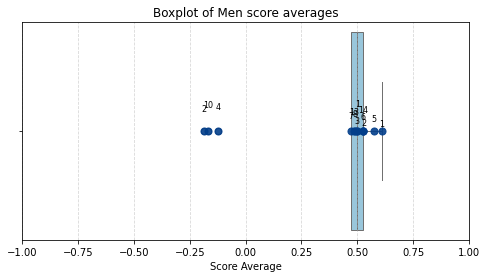

Variance: 0.08366688379152763


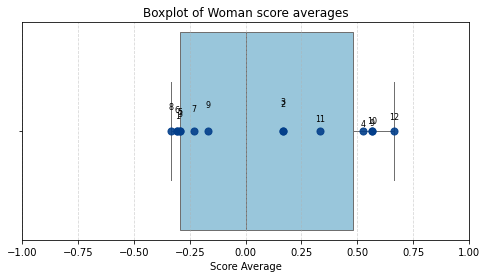

Variance: 0.14306360404244003


In [142]:
plot_avg(df_m, "Boxplot of Men score averages")
plot_avg(df_f, "Boxplot of Woman score averages")

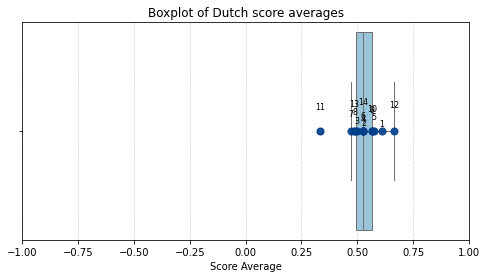

Variance: 0.005420152886257389


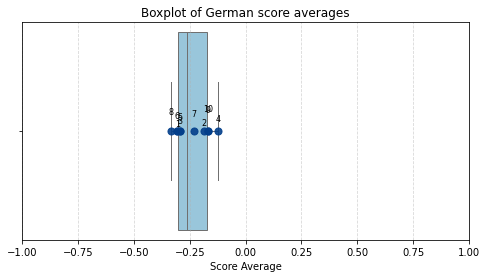

Variance: 0.0050688014403292275


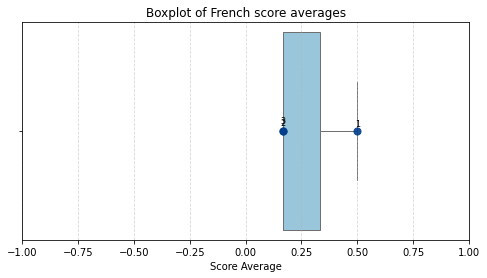

Variance: 0.024691358024691332


In [143]:
plot_avg(dutch_df_extended, "Boxplot of Dutch score averages")
plot_avg(german_df_extended, "Boxplot of German score averages")
plot_avg(french_df_extended, "Boxplot of French score averages")

for every participant avg score
first per query (weighted score)
then avg of 3 query 
weights 



In [144]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Disable line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content in each column

german_df_extended

,Participant,Bild-c,FAZ-c,RTL-c,Sat1-c,Sz-c,ARD-c,Der Spiegel-c,Bild-d,FAZ-d,RTL-d,Sat1-d,Sz-d,ARD-d,Der Spiegel-d,Bild-g,FAZ-g,RTL-g,Sat1-g,Sz-g,ARD-g,Der Spiegel-g,Age,Gender,Nationality,Location,score-c,score-d,score-g,score-avg
0,1,0.0,0.0,0.0,0.0,2.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,4,0.0,0.0,0.0,0.0,2.0,22,f,German,Regensburg,-0.333333,-0.333333,-0.25,-0.305556
1,2,1.0,0.0,0.0,0.0,0.0,"3,5",0,0.0,4.0,0.0,0.0,5.0,0.0,0,0.0,4,0.0,0.0,0.0,0.0,3.0,27,m,German,Freiburg,-0.055556,-0.25,-0.25,-0.185185
2,3,0.0,0.0,0.0,0.0,2.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,"2,5",0.0,"3,4",0.0,0.0,0.0,0.0,1.0,24,f,German,Dusseldorf,-0.333333,-0.333333,-0.222222,-0.296296
3,4,2.0,0.0,0.0,0.0,0.0,"3,5",1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,25,m,German,Nijmegen,-0.125000,<NA>,<NA>,-0.125000
4,5,0.0,0.0,0.0,0.0,2.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,"3,4",0.0,0.0,0.0,0.0,1.0,20,f,German,Nuremberg,-0.333333,-0.333333,-0.222222,-0.296296
5,6,0.0,0.0,0.0,0.0,3.0,0,"1,2",0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,4,0.0,0.0,0.0,0.0,1.0,22,f,German,Nuremberg,-0.333333,-0.333333,-0.25,-0.305556
6,7,3.0,0.0,0.0,0.0,0.0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,3,0.0,0.0,0.0,0.0,1.0,24,f,German,Phuket,-0.111111,-0.333333,-0.25,-0.231481
7,8,0.0,0.0,0.0,0.0,0.0,0,"4,5",0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,5.0,22,f,German,Nuremberg,-0.333333,-0.333333,-0.333333,-0.333333
8,9,0.0,0.0,0.0,0.0,0.0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,24,f,German,Wellington,-0.166667,<NA>,<NA>,-0.166667
9,10,0.0,0.0,0.0,0.0,0.0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,25,m,German,Wellington,-0.166667,<NA>,<NA>,-0.166667
